# Récupération des classes

Récupère le nom de 100 classes différentes du dataset quickdraw.

In [ ]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2022-12-16 14:45:07--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2022-12-16 14:45:08 (38.9 MB/s) - ‘mini_classes.txt’ saved [760/760]



Lecture du fichier contenant le nom des classes.

In [ ]:
f = open("mini_classes.txt","r")
classes = f.readlines()
f.close()

In [ ]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Téléchargement du dataset

In [ ]:
!mkdir data

In [ ]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Imports 

In [ ]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from random import randint

# Chargement des données

Chaque classe contient un fichier .npy contenant les données de plusieurs images. Nous chargons 4000 images par classe.
<br> Les données sont chargées dans un tableau numpy.
<br>Elles sont ensuite randomisées puis séparées en deux parties : une pour l'entrainement(80%) et une pour le test(20%).

In [ ]:
#fonction pour charger des données à partir de fichiers .npy
def load_data(root, vfold_ratio=0.2, max_items_per_class=4000):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialise les variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #charge les données
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #mélange les données
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #sépare les données pour l'entrainement et le test
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [ ]:
#wb => write binary
with open('class_names.npy', 'wb') as f:
  np.save(f, class_names)

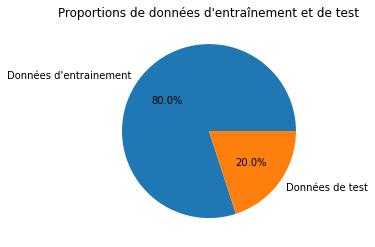

In [ ]:
sizes = [len(x_train), len(x_test)]
plt.pie(sizes, labels=["Données d'entrainement", "Données de test"], autopct='%1.1f%%')
plt.title("Proportions de données d'entraînement et de test")
plt.show()

# Quelques images

(117999, 784)


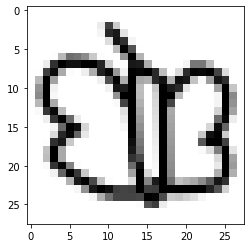

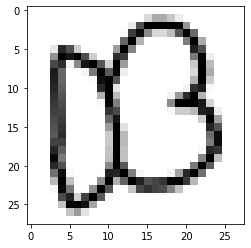

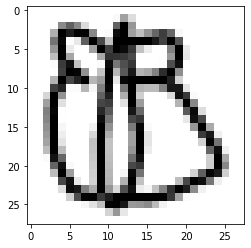

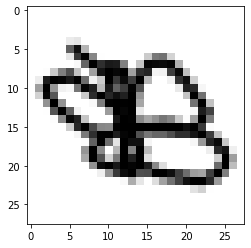

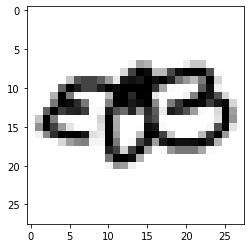

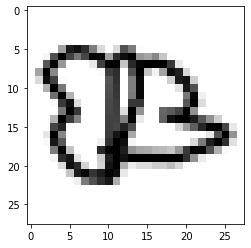

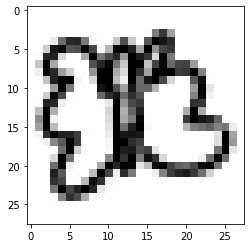

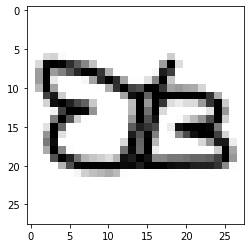

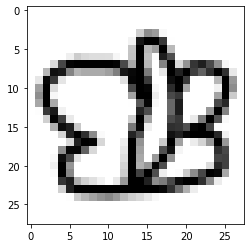

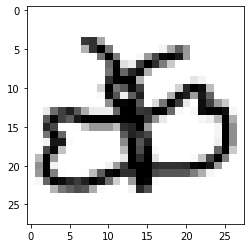

In [ ]:
#Affiche quelques images de la classe butterfly
papillon = np.load("data/butterfly.npy")
print(papillon.shape)
papillon = papillon.reshape(117999,28,28)
for ind in range(10):
  plt.imshow(papillon[ind], cmap='binary')
  plt.show()

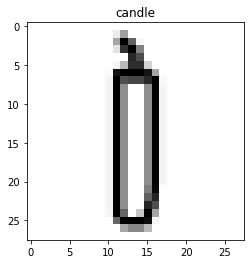

In [ ]:
#Affiche une image aléatoire
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28), cmap='binary')
trash = plt.title(class_names[y_train[idx].argmax()])

# Preprocessing des données



1.   Redimensionnement des images en 28x28 pixels
2.   Normalisation des pixels entre 0 et 1 au lieu de 0 et 255.

In [ ]:
# Redimensionne pour avoir des images 28*28
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

# Normalise les valeurs entre 0 et 1
x_train /= 255.0
x_test /= 255.0

# Convertis les vecteurs en matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Le modèle

Altérnance de couches de convolution et de couches de pooling pour extraire les caractéristiques des images.

In [ ]:
# Defini le modele de CNN
model = keras.Sequential()
#Couche de convolution avec 16 filtres de taille 3*3 et une fonction d'activation relu.
model.add(layers.Convolution2D(16, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
#Couche de pooling avec une fenetre de taille 2*2
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 

model.compile(loss='categorical_crossentropy',
              metrics=['top_k_categorical_accuracy'])

Chaque couche Conv2D et MaxPooling2D est un tenseur 3D de forme (hauteur, largeur, canaux).
<br>Les dimensions de largeur et de hauteur ont tendance à diminuer à mesure que l'on progresse dans le réseau.
<br>Le dernier tenseur de taille 3,3,64 est aplati en un vecteur de taille 576 pour pouvoir être passé en entrée d'une couche Dense qui prends un vercteur 1D.
<br>Les couches Dense sont des couches classiques de réseaux de neurones.
<br>La couche de sortie est une couche Dense avec 100 neurones et une fonction d'activation softmax qui renvoie la probabilité de chaque classe.
<br>La fonction de perte est une cross entropy car nous travaillons sur de la classification.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

# Entrainement du modèle 

Le modèle est entrainé pendant 5 epochs avec un batch size de 256.
<br>Les epochs sont des itérations sur l'ensemble des données d'entrainement.
<br>Le batch size est le nombre d'image envoyé dans le réseau avant de mettre à jour les poids.


In [ ]:
history = model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=1, epochs=5)

Epoch 1/5
1125/1125 [==============================] - 29s 11ms/step - loss: 2.0146 - top_k_categorical_accuracy: 0.7661 - val_loss: 1.4362 - val_top_k_categorical_accuracy: 0.8696
Epoch 2/5
1125/1125 [==============================] - 11s 10ms/step - loss: 1.2631 - top_k_categorical_accuracy: 0.8905 - val_loss: 1.1431 - val_top_k_categorical_accuracy: 0.9036
Epoch 3/5
1125/1125 [==============================] - 10s 9ms/step - loss: 1.0806 - top_k_categorical_accuracy: 0.9105 - val_loss: 1.0405 - val_top_k_categorical_accuracy: 0.9153
Epoch 4/5
1125/1125 [==============================] - 15s 13ms/step - loss: 0.9825 - top_k_categorical_accuracy: 0.9209 - val_loss: 0.9958 - val_top_k_categorical_accuracy: 0.9197
Epoch 5/5
1125/1125 [==============================] - 7s 7ms/step - loss: 0.9175 - top_k_categorical_accuracy: 0.9274 - val_loss: 0.9588 - val_top_k_categorical_accuracy: 0.9228


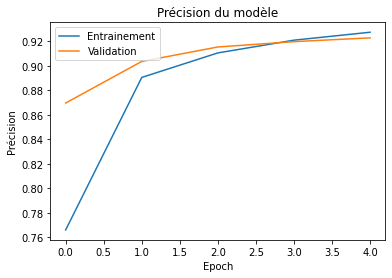

In [ ]:
#Affiche les courbes d'entrainement
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Epoch')
plt.legend(['Entrainement', 'Validation'], loc='upper left')
plt.show()

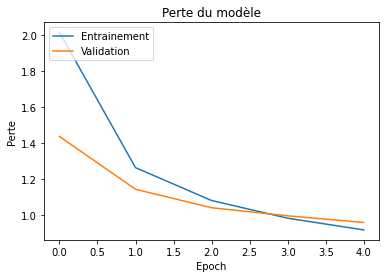

In [ ]:
#Affiche la courbe de perte
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Epoch')
plt.legend(['Entrainement', 'Validation'], loc='upper left')
plt.show()

# Fonctions de prédiction et de lecture d'images

In [ ]:
def readImg(imName):
  im = cv2.imread(imName) #shape = (700,725,3)
  #Redimensionne l'image pour avoir une taille de 28*28 avec une interpolation
  im = cv2.resize(im, (28,28), interpolation = cv2.INTER_AREA) #shape = (28,28,3)
  #Convertis l'image en niveaux de gris
  im = im[:, :, 0:1] #shape = (28,28,1)
  im = im.astype('float64')
  #Normalise les valeurs entre 0 et 1
  im = 1 - im/255
  #Binarise l'image
  treshold = 0.2
  bool = (im > treshold)
  im[bool] = 1
  return im

def predictImg(mymodel, myimage):
  plt.imshow(myimage.squeeze(), cmap='binary') #Affiche image

  pred = mymodel.predict(np.expand_dims(myimage, axis=0))[0]
  indice = (-pred).argsort()[:5]
  #Récupère les noms des 5 meilleures classes
  latex = [class_names[x] for x in indice]
  print(latex)
  return pred, indice, latex

# Test du modèle

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test de précison: {:0.2f}%'.format(score[1] * 100))

Test de précison: 92.00%


Prédiction sur les données de test.

1/1 [==============================] - 0s 17ms/step
['mushroom', 'tree', 'umbrella', 'hammer', 'spoon']


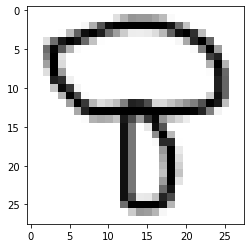

In [ ]:
#Image aléatoire
idx = randint(0, len(x_test))
randImg = x_test[idx]
trash = predictImg(model, randImg)

# Test sur image importée

On importe une image de taille 700x725x3, on la redimensionne en 28x28 pixels et on la normalise avant d'en faire la prédiction.

1/1 [==============================] - 0s 20ms/step
['t-shirt', 'bread', 'anvil', 'mushroom', 'tree']


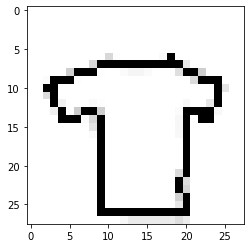

In [ ]:
x_im = readImg('tshirt.png')
predict, indice, labels = predictImg(model, x_im)

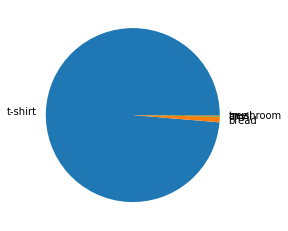

In [ ]:
trash = plt.pie(predict[indice], labels=labels)

# Sauvegarder convertir et télécharger le modèle

In [ ]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [ ]:
%%capture
!pip install tensorflowjs 

In [ ]:
model.save('keras.h5')

In [ ]:
#with open('model.sav', 'wb') as files:
#    pickle.dump(model, files, protocol=2)

#with open('model.pkl' , 'rb') as f:
#    lr = pickle.load(f)

In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

2022-12-16 14:53:34.056238: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-12-16 14:53:34.056995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-12-16 14:53:34.057022: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/model.json (deflated 82%)
  adding: model/class_names.txt (deflated 41%)


In [ ]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>